In [1]:
import os
os.chdir('/Users/Olivier/anaconda3/envs/FEM')
%load_ext autoreload

In [2]:
%autoreload 2
from FEMOL import RectangleQuadMesh, FEM_Problem, TOPOPT_Problem
from FEMOL_utils import *

In [25]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.optimize
from matplotlib.colors import LogNorm

# Cantilever Square Topology Optimization

## Mesh

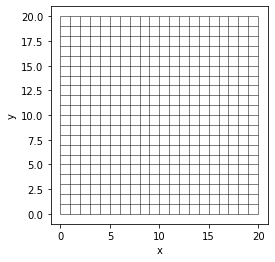

In [81]:
nelx = 20 # elements in the x direction
nely = 20 # elements in the y direction

# Creating the mesh
Lx = nelx
Ly = nely

plt.figure()
mesh = RectangleQuadMesh(Lx, Ly, nelx, nely)
mesh.plot()

### Cantilever Square Topology Optimization Problem

Defining the FEM problem

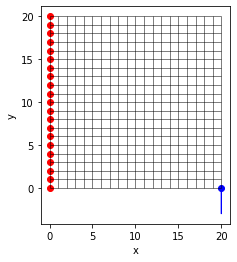

In [82]:
# Material proprieties
E = 1
nu = 0.3
t = 1 # thickness

# Creating the FEM Problem
Problem = FEM_Problem(mesh) # initialize the problem
Problem.isotropic_plane_stress_tensor(E, nu, t) # Define the stiffness tensor
Problem.plane_stress_Ke() # Get the element stiffness matrix (constant for every element)

# Boundary condition domains :

# Fixed nodes on the left side
x = [0]
y = [[0, Ly]]
fixed_domain_1 = create_domain(x, y)


# Domain where the down force is applied
x = [Lx]
y = [0]
force_domain = create_domain(x, y)

# Defining the force
force = [0, -1] #  Force = [Fx, Fy]


Problem.assemble_plane_stress()
Problem.add_fixed_domain(fixed_domain_1)
Problem.add_forces(force, force_domain)
Problem.fix_boundary()
Problem.plot()

## Benchmark optimization

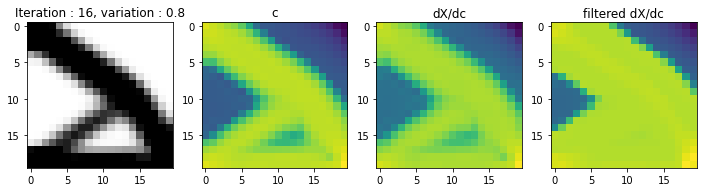

In [83]:
TOPOPT = TOPOPT_Problem(Problem)

converge=0.01
max_loops=100
animate=True
c_values = []
dc_values = []
filterd_dc = []
X_values = []

change = 1
loop = 0
if animate:
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(12,6))
    clear_output(wait=True)

while (change > converge) & (loop < max_loops):
    Xold = TOPOPT.X
    loop += 1

    TOPOPT.single_material_FEM(Xold)
    TOPOPT.c, TOPOPT.dc, c_array = TOPOPT.objective_function(Xold, return_c_array=True)
    
    c_values.append(c_array)
    dc_values.append(TOPOPT.dc)
    X_values.append(Xold)
    
    TOPOPT.filter_sensibility(Xold)
    filterd_dc.append(TOPOPT.dc)
    TOPOPT.X = TOPOPT.get_new_x(Xold)
    change = np.max(np.abs(TOPOPT.X - Xold))
    TOPOPT.results.X_solutions.append(TOPOPT.X)

    if animate:
        X_plot = np.flip(X_values[-1].reshape(TOPOPT.mesh.nely, TOPOPT.mesh.nelx), axis=0)
        fdc_plot = np.flip(filterd_dc[-1].reshape(TOPOPT.mesh.nely, TOPOPT.mesh.nelx), axis=0)
        dc_plot = np.flip(dc_values[-1].reshape(TOPOPT.mesh.nely, TOPOPT.mesh.nelx), axis=0)
        c_plot = np.flip(c_values[-1].reshape(TOPOPT.mesh.nely, TOPOPT.mesh.nelx), axis=0)
        clear_output(wait=True)
        
        ax1.imshow(X_plot, cmap='Greys')
        title = "Iteration : " + str(loop) + ', variation : ' + str(np.around(change * 100, 1))
        ax1.set_title(title)
        
        ax2.imshow(c_plot, norm=LogNorm(vmin=c_plot.min(), vmax=c_plot.max()))
        ax2.set_title('c')
        
        ax3.imshow(np.abs(dc_plot), norm=LogNorm(vmin=np.abs(dc_plot).min(), vmax=np.abs(dc_plot).max()))
        ax3.set_title('dX/dc')
        
        ax4.imshow(np.abs(fdc_plot), norm=LogNorm(vmin=np.abs(fdc_plot).min(), vmax=np.abs(fdc_plot).max()))
        ax4.set_title('filtered dX/dc')
        
        plt.tight_layout
        
        display(fig)
        plt.pause(0.1)
        
Result = TOPOPT.results

## Solving without gradient

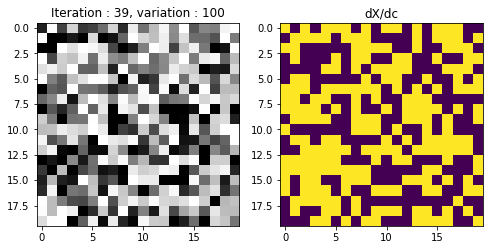

IndexError: index 40 is out of bounds for axis 0 with size 40

In [110]:
TOPOPT = TOPOPT_Problem(Problem)

# Loop parameters
change = 1
loop = 0
converge=0.04
max_loops=40
damping = np.exp(-np.linspace(0, 10, max_loops))

# List to store iterations
c_values = []
dc_values = []
filterd_dc = []
X_values = []

# Dynamic display figure
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,6))
clear_output(wait=True)

# Initial values
X_values.append(TOPOPT.X)
X_values.append(np.random.rand(TOPOPT.X.shape[0]))

# Optimisation loop
while (loop < max_loops) and (change > converge):
    loop += 1

    TOPOPT.single_material_FEM(X_values[-1])
    c1, _, c_array1 = TOPOPT.objective_function(Xold, return_c_array=True)
    
    TOPOPT.single_material_FEM(X_values[-2])
    c2, _, c_array2 = TOPOPT.objective_function(Xold, return_c_array=True)
    
    dC = c1 - c2
    dX = X_values[-1] - X_values[-2]
    
    dc = dC/dX
    dc[dX==0] = 0
    dc[dc>0] = 0
    TOPOPT.dc = (dc)*damping[loop]
    
    dc_values.append(TOPOPT.dc)
    
    #TOPOPT.filter_sensibility(Xold)
    #filterd_dc.append(TOPOPT.dc)
    
    X_values.append(TOPOPT.get_new_x(X_values[-1]))
    #change = np.max(np.abs(TOPOPT.X - Xold))
    #TOPOPT.results.X_solutions.append(TOPOPT.X)

    X_plot = np.flip(X_values[-1].reshape(TOPOPT.mesh.nely, TOPOPT.mesh.nelx), axis=0)
    dc_plot = np.flip(dc_values[-1].reshape(TOPOPT.mesh.nely, TOPOPT.mesh.nelx), axis=0)
    clear_output(wait=True)

    ax1.imshow(X_plot, cmap='Greys')
    title = "Iteration : " + str(loop) + ', variation : ' + str(np.around(change * 100, 1))
    ax1.set_title(title)


    ax2.imshow(np.abs(dc_plot))
    ax2.set_title('dX/dc')

    plt.tight_layout

    display(fig)
    plt.pause(0.1)
        
Result = TOPOPT.results

In [106]:
np.exp(-np.linspace(0, 3, ))

array([1.00000000e+00, 3.67879441e-01, 1.35335283e-01, 4.97870684e-02,
       1.83156389e-02, 6.73794700e-03, 2.47875218e-03, 9.11881966e-04,
       3.35462628e-04, 1.23409804e-04])

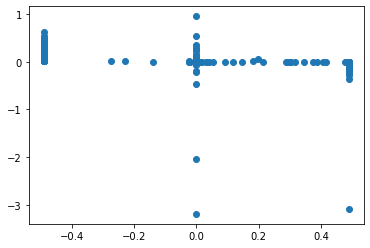

In [97]:
fig, ax = plt.subplots()

key = np.argsort(dX)

ax.scatter(dX[key], dC[key])